# Data 512 Part 2 - Project Extension
In this section, we will build off of the model that was constructed in part 1.

The initial plan for the extension was to quantify the economic impact of rising smoke levels on the city. But finding relevant data was near impossible so I pivoted to a simpler task. In this section, I will be building on my smke estimate from part 1 and constructing a human impact metric that aims to meausre the impact of the rising smoke levels on the increasing number of tourists to the city.

## Data Aquisition:
The dataset I am using was provided by the city of Savannah, GA. The city's data page has a helpline that can be contacted, and through this line, I was able to request tourism numbers dating back to 1980.

## Creating the Human Impact Metric
We need to combine the smoke estimate from part 1 and the tourism data. To do this, we can use the MinMaxScaler library. Once these fields are normalized, we can combine them to create our aggregated human impact metric.


In [19]:
import os, json, time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install geojson
import geojson

!pip install prophet
from prophet import Prophet


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
from sklearn.preprocessing import MinMaxScaler

Read in the wildfire data from part 1. Filter the data to fires within 650 miles and fires in the time period 1980 to 2023. Calculate the smoke estimate using the same formula as part 1 and scale it to be roughly in the same range as the AQI values.

In [30]:
df = pd.read_csv("parsed_data.csv")
df['distance'] = df['distance'].astype(int)

df_savannah = df[(df['year'] >= 1980) & (df['year'] <= 2023) & (df['distance'] <= 650)]
df_savannah['smoke_estimate'] = 1.5 * df_savannah['size'] / (df['distance'] ** 2)

df_smoke_totals = df_savannah.groupby('year')['smoke_estimate'].sum().reset_index()

C:\Users\ashwi\AppData\Local\Temp\ipykernel_14756\917974032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_savannah['smoke_estimate'] = 1.5 * df_savannah['size'] / (df['distance'] ** 2)


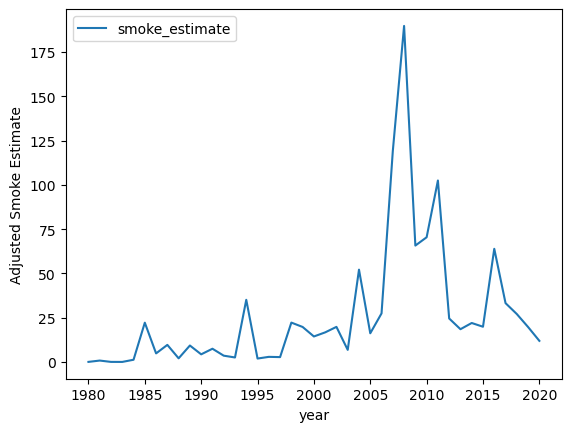

In [31]:
df_smoke_totals.plot(x='year', y='smoke_estimate', kind='line')
plt.ylabel('Adjusted Smoke Estimate')
plt.show()

Visualize the tourism data.

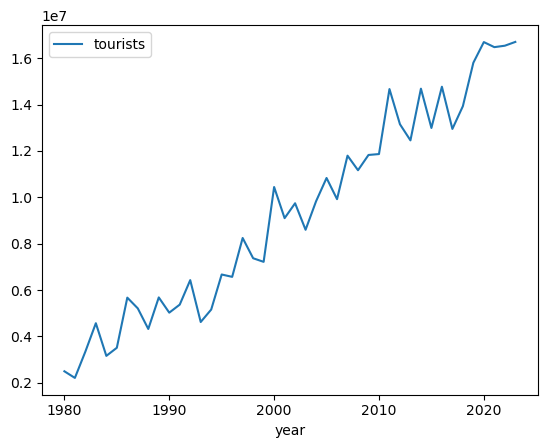

In [34]:
df_tourism = pd.read_csv("tourist_data.csv")
df_tourism.plot(x='year', y='tourists', kind='line')
plt.show()

Merge the tourism data with the smoke estimate data. Join by the year, and discard the rows where year does not have a match.
Then, normalize the data using MinMaxScaler and calculate the aggragated human impact metric. Finally, plot this new metric.

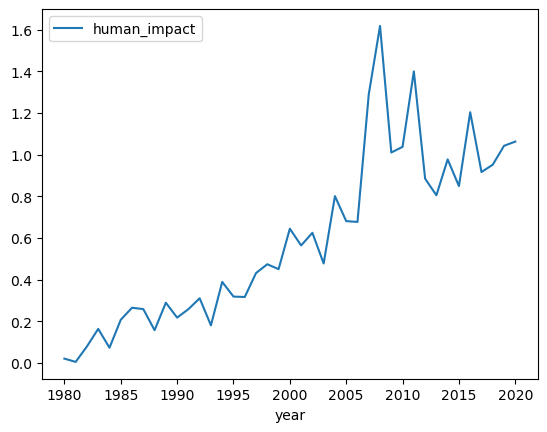

In [52]:
merged_df = pd.merge(df_smoke_totals, df_tourism, on='year', how='inner')

scaler = MinMaxScaler()

# Normalize Smoke Estimate (between 0 and 1)
merged_df['norm_smoke_estimate'] = scaler.fit_transform(merged_df[['smoke_estimate']])


# Normalize Tourism (between 0 and 1)
# Scaling tourism between 2 and 17 million
tourism_scaler = MinMaxScaler(feature_range=(0, 1))
merged_df['norm_tourists'] = tourism_scaler.fit_transform(merged_df[['tourists']])

# Calculate Human Impact Metric as a weighted sum of the normalized values
merged_df['human_impact'] = merged_df['norm_smoke_estimate'] + merged_df['norm_tourists']

merged_df.plot(x='year', y='human_impact', kind='line')
plt.show()

Use the prophet library to create a model of the human impact metric and use it to make a prediction up to 2050.

22:02:37 - cmdstanpy - INFO - Chain [1] start processing
22:02:37 - cmdstanpy - INFO - Chain [1] done processing


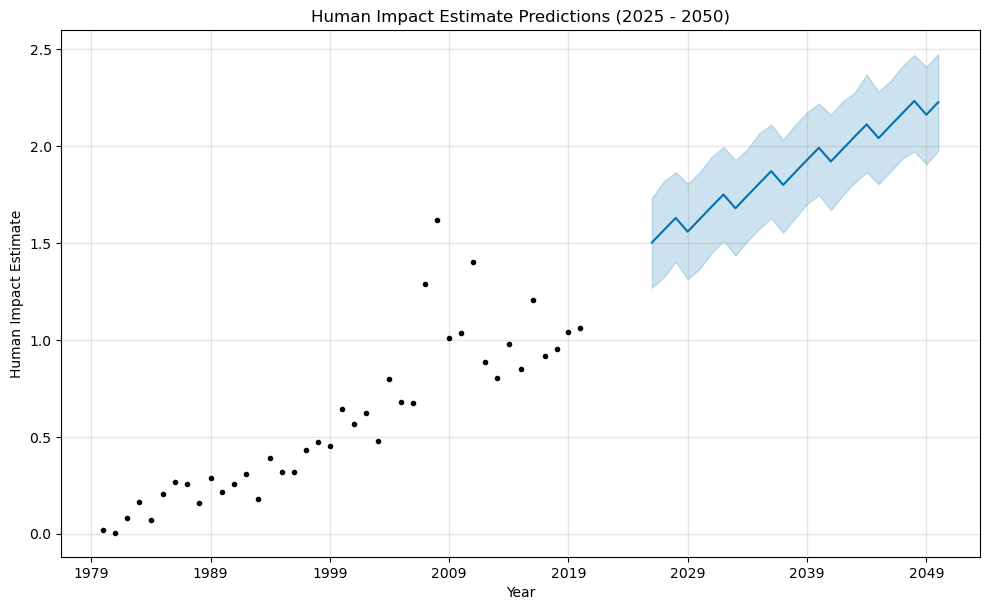

In [53]:
df_prophet = merged_df.rename(columns={'year': 'ds', 'human_impact': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

# Fit the model
model = Prophet()
model.fit(df_prophet)

# Make the predictions
future_years = pd.DataFrame({'ds': pd.date_range(start='2025', end='2050', freq='Y')})
forecast = model.predict(future_years)

# Plot the results
fig = model.plot(forecast)
plt.title("Human Impact Estimate Predictions (2025 - 2050)")
plt.xlabel("Year")
plt.ylabel("Human Impact Estimate")
plt.show()